In [163]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats

import json
from datetime import datetime

import chess.pgn
import io
import re

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Allow max viewability for dataframes
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [55]:
# Reset viewability
pd.reset_option('display.max_rows')

In [3]:
chess_df = pd.read_csv('../../data/SampleGames_RU_1500_formatted.csv')

In [4]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231559 entries, 0 to 231558
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   username      231559 non-null  object
 1   white_rating  231559 non-null  int64 
 2   black_rating  231559 non-null  int64 
 3   rating_diff   231559 non-null  int64 
 4   termination   231559 non-null  object
 5   ECO           231559 non-null  object
 6   total_moves   231559 non-null  int64 
 7   total_turns   231559 non-null  int64 
 8   moves_list    231559 non-null  object
 9   time_class    231559 non-null  object
 10  rated         231559 non-null  bool  
 11  date          231559 non-null  object
 12  year          231559 non-null  int64 
 13  month         231559 non-null  int64 
 14  day           231559 non-null  int64 
 15  white         231559 non-null  object
 16  black         231559 non-null  object
 17  pgn           231559 non-null  object
 18  fen           231559 non

In [41]:
chess_df.describe()

,white_rating,black_rating,rating_diff,total_moves,total_turns,year,month,day,user_rating,avg_rating
count,231559.000000,231559.000000,231559.000000,231559.000000,231559.000000,231559.000000,231559.000000,231559.000000,231559.000000,231559.000000
mean,1333.851161,1333.086876,59.848699,65.904892,32.693387,2019.233301,8.234277,15.997737,1333.510552,1333.469019
std,374.001754,373.986160,103.954446,30.825989,15.421607,1.317771,3.297538,8.849447,377.636463,369.153794
min,100.000000,100.000000,0.000000,1.000000,0.000000,2015.000000,1.000000,1.000000,100.000000,125.500000
25%,1078.000000,1077.000000,16.000000,45.000000,22.000000,2018.000000,4.000000,8.000000,1077.000000,1078.000000
50%,1312.000000,1312.000000,34.000000,62.000000,31.000000,2020.000000,8.000000,16.000000,1312.000000,1309.500000
75%,1588.000000,1586.000000,62.000000,84.000000,42.000000,2020.000000,12.000000,24.000000,1590.000000,1585.500000
max,2997.000000,3037.000000,2081.000000,309.000000,154.000000,2020.000000,12.000000,31.000000,2830.000000,2902.500000


In [42]:
chess_df.describe().loc[['mean','std','min','25%','50%','75%','max'],['white_rating','black_rating','rating_diff','total_moves','avg_rating']]

,white_rating,black_rating,rating_diff,total_moves,avg_rating
mean,1333.851161,1333.086876,59.848699,65.904892,1333.469019
std,374.001754,373.986160,103.954446,30.825989,369.153794
min,100.000000,100.000000,0.000000,1.000000,125.500000
25%,1078.000000,1077.000000,16.000000,45.000000,1078.000000
50%,1312.000000,1312.000000,34.000000,62.000000,1309.500000
75%,1588.000000,1586.000000,62.000000,84.000000,1585.500000
max,2997.000000,3037.000000,2081.000000,309.000000,2902.500000


In [6]:
chess_df['avg_rating'] = (chess_df['white_rating'] + chess_df['black_rating'])/2

In [7]:
# Convert date to datetime format
chess_df['date'] = pd.to_datetime(chess_df.date)

In [5]:
# Add column denoting what color user is
user_color = []
user_rating = []
for i in range(len(chess_df)):
    if eval(chess_df['white'][i])['username'].lower() == chess_df['username'][i].lower():
        user_color.append('white')
        user_rating.append(eval(chess_df['white'][i])['rating'])
    else:
        user_color.append('black')
        user_rating.append(eval(chess_df['black'][i])['rating'])
        
chess_df['user_color'] = user_color
chess_df['user_rating'] = user_rating

In [8]:
# View number of games in each category
print('bullet: ' + str(sum(chess_df['time_class'] == 'bullet')))
print('blitz: ' + str(sum(chess_df['time_class'] == 'blitz')))
print('rapid: ' + str(sum(chess_df['time_class'] == 'rapid')))
print('daily: ' + str(sum(chess_df['time_class'] == 'daily')))

bullet: 39419
blitz: 159269
rapid: 28837
daily: 4034


In [9]:
# Max-Min for ratings
print('White Max: ' + str(chess_df['white_rating'].max()))
print('Black Max: ' + str(chess_df['black_rating'].max()))
print('White Min: ' + str(chess_df['white_rating'].min()))
print('Black Min: ' + str(chess_df['black_rating'].min()))

White Max: 2997
Black Max: 3037
White Min: 100
Black Min: 100


### Turns per Game vs Average Rating Between Both Players

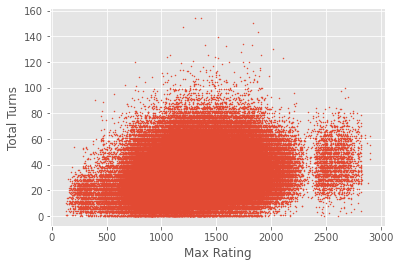

In [10]:
fig, ax = plt.subplots()
ax.scatter(chess_df['avg_rating'],chess_df['total_turns'],s=1)
ax.set_xlabel('Max Rating')
ax.set_ylabel('Total Turns')
plt.show()

In [11]:
# Create dataframes for each time class
bullet_df = chess_df[chess_df['time_class'] == 'bullet']
blitz_df = chess_df[chess_df['time_class'] == 'blitz']
rapid_df = chess_df[chess_df['time_class'] == 'rapid']
daily_df = chess_df[chess_df['time_class'] == 'daily']

### Turn Distribution per Time Class 

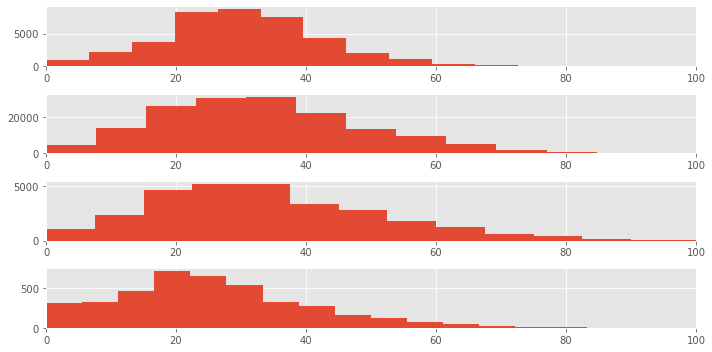

In [12]:
fig, axs = plt.subplots(4,1, figsize = (10,5))
axs[0].hist(bullet_df['total_turns'].values, bins=20)
axs[1].hist(blitz_df['total_turns'].values, bins=20)
axs[2].hist(rapid_df['total_turns'].values, bins=20)
axs[3].hist(daily_df['total_turns'].values, bins=20)

# Standardize axes limits for all graphs
plt.setp(axs, xlim=(0, 100))

plt.tight_layout()
plt.show()

# Year over Year Analysis

In [13]:
# Edge-case handling where game started in one year but completed in another
idx = chess_df[chess_df['year']==2016].index.values
for i in idx:
    chess_df.at[i,'year'] = 2015
    
idx = chess_df[chess_df['year']==2019].index.values
for i in idx:
    chess_df.at[i,'year'] = 2018

idx = chess_df[chess_df['year']==2021].index.values
for i in idx:
    chess_df.at[i,'year'] = 2020

In [14]:
for year in sorted(chess_df['year'].unique()):
    print(str(year) + ':')
    print('Mean: ' + str(chess_df[chess_df.year==year]['total_moves'].mean()))
    print('Standard Deviation: ' + str(chess_df[chess_df.year==year]['total_moves'].std()))
    print('Max: ' + str(chess_df[chess_df.year==year]['total_moves'].max()))
    print('Min: ' + str(chess_df[chess_df.year==year]['total_moves'].min()))

2015:
Mean: 70.37665847665848
Standard Deviation: 32.2443659527085
Max: 287
Min: 1
2018:
Mean: 68.30520405885686
Standard Deviation: 31.097125142696708
Max: 309
Min: 1
2020:
Mean: 64.69822352984991
Standard Deviation: 30.53440473693739
Max: 308
Min: 1


### Total Moves Distribution per Year

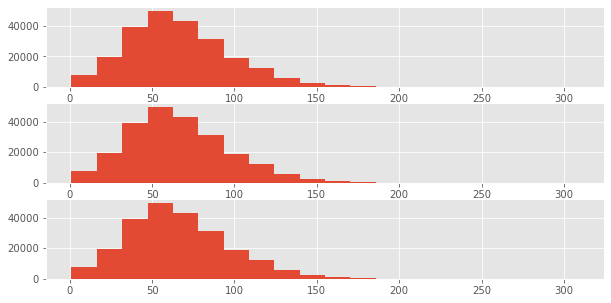

In [15]:
fig, axs = plt.subplots(3,1,figsize=(10,5))
for idx, year in enumerate(sorted(chess_df['year'].unique())):
    axs[idx].hist(chess_df['total_moves'].values, bins = 20)

plt.show()

In [16]:
chess_df.groupby('ECO').total_turns.mean().sort_values(ascending=False)

ECO
Alekhines-Defense-Scandinavian-Variation-3.exd5-Nxd5-4.Bc4-Nb6    130.0
Sicilian-Defense-Open-Dragon-Belezky-Line-8.Bc4                    86.0
Sicilian-Defense-Open-Dragon-Main-Line-9...Bd7-10.h4               85.0
English-Opening-Fianchetto-Ultra-Symmetrical-Duchamp-Variation     85.0
Polish-Opening-Schiffler-Sokolsky-Variation                        82.0
                                                                  ...  
Modern-Defense-Fianchetto-Gambit                                    4.0
Dutch-Defense-Alapin-Variation-Anti-Leningrad-Variation             3.0
Kings-Pawn-Opening-Kings-Knight-Irish-Gambit                        2.0
Barnes-Opening-Fools-Mate                                           2.0
Grob-Opening-Grob-Gambit-2...Bxg4                                   2.0
Name: total_turns, Length: 4438, dtype: float64

# Player Exploration

In [17]:
print('Total number of players: ' + str(len(chess_df['username'].unique())))

Total number of players: 383


In [18]:
# Top 10 players by number of games played for the blitz time class
chess_df[chess_df.time_class=='blitz'].groupby('username').count()['ECO'].sort_values(ascending=False).head(10)

username
divididividi    3571
sagarns         3391
serggggggg      2859
tinkagain       2718
zhenya-004      2600
murat00009      2410
kilelya         2307
aas521          2275
antonezku       2232
toneek          2173
Name: ECO, dtype: int64

In [19]:
top_10_blitz = list(chess_df[chess_df.time_class=='blitz'].groupby('username').count()['ECO'].sort_values(ascending=False).head(10).index)

### Top 10 Players' Ratings over Time

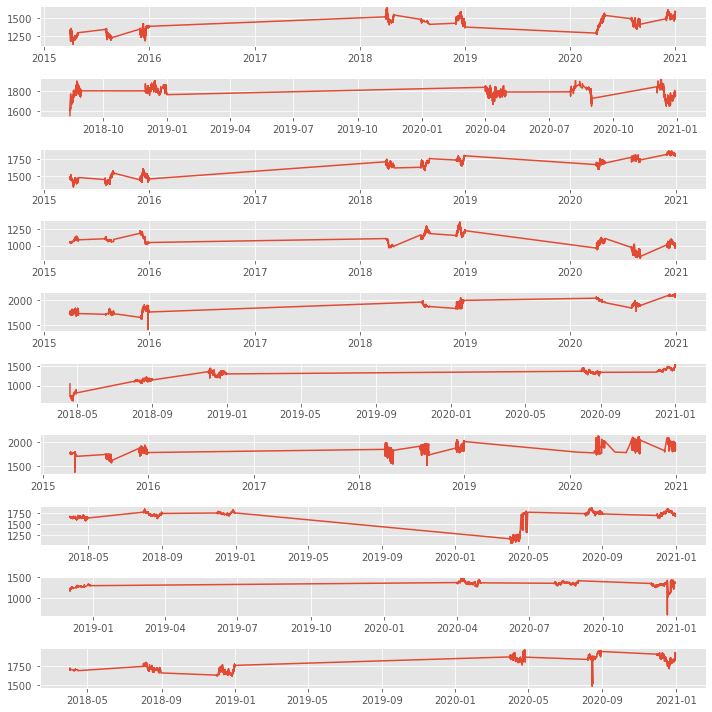

In [20]:
fig, axs = plt.subplots(10,1, figsize=(10,10))

for idx, player in enumerate(top_10_blitz):
    df = chess_df[chess_df.username==player].sort_values('date')
    axs[idx].plot(df.date, df.user_rating)
    
plt.tight_layout()
plt.show()

In [22]:
for user in top_10_blitz:
    print('Player: ' + user)
    print(chess_df[(chess_df.time_class=='blitz') & (chess_df.username==user)].sort_values('date').groupby(['year','month']).agg({'user_rating':['mean','min','max']}))
    
    

Player: divididividi
            user_rating            
                   mean   min   max
year month                         
2015 4      1237.812357  1131  1353
     8      1257.634483  1189  1350
     12     1308.348684  1180  1418
2018 1      1380.687500  1357  1410
     4      1501.447802  1405  1634
     8      1450.188679  1408  1483
     12     1481.079585  1380  1587
2020 1      1581.125000  1574  1591
     4      1442.009434  1268  1563
     5      1526.800000  1518  1534
     8      1423.501761  1344  1502
     9      1408.181818  1370  1438
     12     1524.540166  1457  1613
Player: sagarns
            user_rating            
                   mean   min   max
year month                         
2018 1      1769.666667  1764  1773
     8      1774.222841  1557  1897
     12     1818.008368  1757  1901
2020 4      1775.675338  1669  1855
     8      1793.740741  1652  1903
     12     1763.191841  1652  1914
Player: serggggggg
            user_rating            
        

### Top 10's Monthly Rating Averages over Time

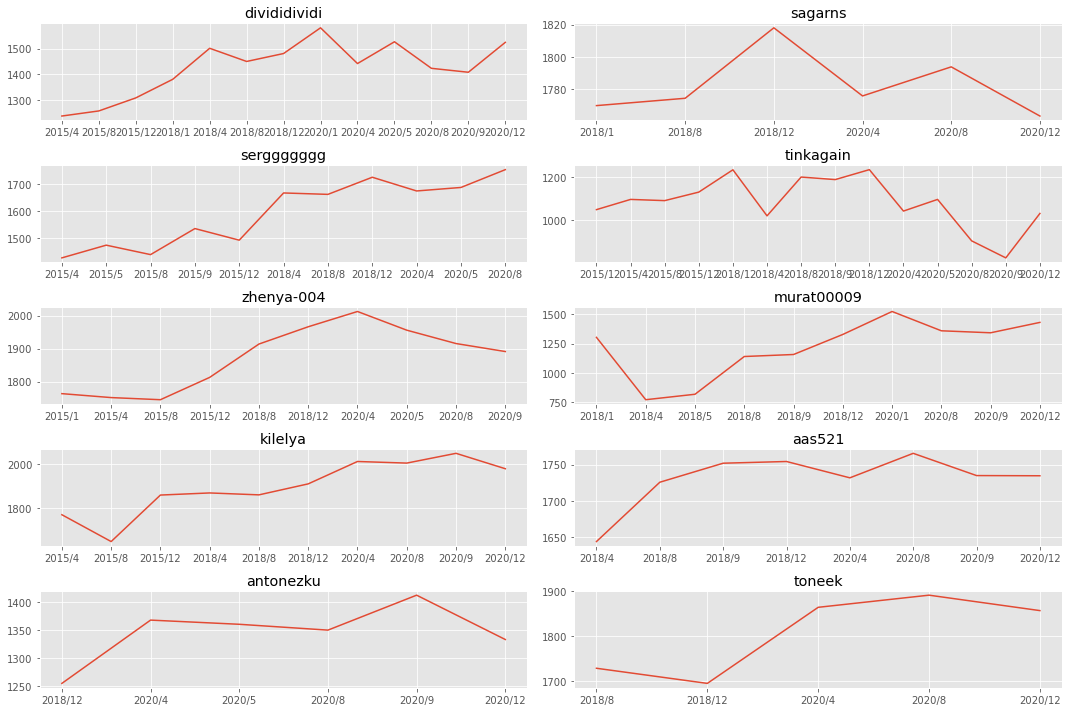

In [25]:
fig, axs = plt.subplots(5,2, figsize=(15,10))

for idx, ax in enumerate(axs.flatten()):
    df = chess_df[(chess_df.time_class=='blitz') & (chess_df.username==top_10_blitz[idx])].sort_values('date').groupby(['year','month']).agg({'user_rating':'mean'})
    ax.plot([str(i[0])+'/'+str(i[1]) for i in df.index], df.user_rating)
    ax.set_title(top_10_blitz[idx])
    
plt.tight_layout()
plt.show()

In [26]:
chess_df[(chess_df.time_class=='blitz') & (chess_df.username==top_10[0])].sort_values('date').groupby(['year','month']).agg({'user_rating':'mean'}).

SyntaxError: invalid syntax (<ipython-input-26-b8abc44d7a0a>, line 1)

# Rating Exploration

In [27]:
print('ELO: 2700+' + '\n')
print(chess_df[chess_df['avg_rating'] > 2700].ECO.value_counts())
print('')
print('ELO: 2500-2700' + '\n')
print(chess_df[(chess_df['avg_rating'] > 2500) & (chess_df['avg_rating'] < 2700)].ECO.value_counts())
print('')
print('ELO: 2400-2500' + '\n')
print(chess_df[(chess_df['avg_rating'] > 2400) & (chess_df['avg_rating'] < 2500)].ECO.value_counts())
print('')
print('ELO: 2300-2400' + '\n')
print(chess_df[(chess_df['avg_rating'] > 2300) & (chess_df['avg_rating'] < 2400)].ECO.value_counts())

ELO: 2700+

Reti-Opening-Kingside-Fianchetto-Variation                       16
Saragossa-Opening                                                10
Nimzowitsch-Larsen-Attack-Modern-Variation-2.Bb2-Nc6-3.e3         9
Modern-Defense-with-1-d4                                          8
Reti-Opening-1...d5                                               7
                                                                 ..
Clemenz-Opening                                                   1
Sicilian-Defense-Alapin-Variation...3.e5-Nd5-4.d4-cxd4-5.Qxd4     1
Queens-Gambit-Accepted-Alekhine-Variation-4.e3-Bg4-5.Bxc4-e6      1
Catalan-Opening-Closed-4...Bb4-5.Nd2-O-O                          1
Kings-Indian-Attack-Yugoslav-Variation                            1
Name: ECO, Length: 212, dtype: int64

ELO: 2500-2700

Nimzowitsch-Larsen-Attack-Classical-Variation-2.Bb2          43
Nimzowitsch-Larsen-Attack-Modern-Variation-2.Bb2-Nc6-3.e3    39
Caro-Kann-Defense-Advance-Variation                       

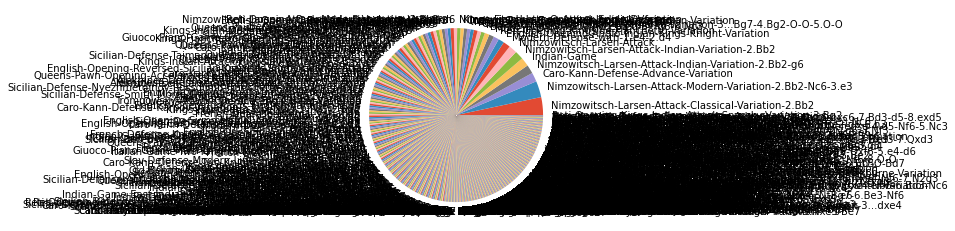

In [77]:
fig, ax = plt.subplots()
ax.pie(chess_df[(chess_df['avg_rating'] > 2500) & (chess_df['avg_rating'] < 2700)].ECO.value_counts().values,
       labels=chess_df[(chess_df['avg_rating'] > 2500) & (chess_df['avg_rating'] < 2700)].ECO.value_counts().index)
plt.show()

In [29]:
chess_df[(chess_df['avg_rating'] > 2500) & (chess_df['avg_rating'] < 2700)].ECO.value_counts()

Nimzowitsch-Larsen-Attack-Classical-Variation-2.Bb2          43
Nimzowitsch-Larsen-Attack-Modern-Variation-2.Bb2-Nc6-3.e3    39
Caro-Kann-Defense-Advance-Variation                          22
Nimzowitsch-Larsen-Attack-Indian-Variation-2.Bb2             21
Indian-Game                                                  21
                                                             ..
English-Opening-Reversed-Sicilian-Variation                   1
Queens-Pawn-Opening                                           1
Bishops-Opening-Berlin-Vienna-Hybrid-Variation                1
Old-Benoni-Defense-2.d5-d6                                    1
English-Opening-Reversed-Sicilian-Variation-2...d6-3.g3       1
Name: ECO, Length: 564, dtype: int64

In [30]:
# Games per rating group
rating_breakout = [0, 800, 1200, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700, 3500]
for idx in range(len(rating_breakout)-1):
    print(f'Number of games for ELO range {rating_breakout[idx]}-{rating_breakout[idx+1]}: ' + str(chess_df[(chess_df['avg_rating'] > rating_breakout[idx]) & (chess_df['avg_rating'] < rating_breakout[idx+1])].shape[0]))
    

Number of games for ELO range 0-800: 13678
Number of games for ELO range 800-1200: 75418
Number of games for ELO range 1200-1600: 86957
Number of games for ELO range 1600-1800: 32022
Number of games for ELO range 1800-2000: 16014
Number of games for ELO range 2000-2200: 4230
Number of games for ELO range 2200-2300: 430
Number of games for ELO range 2300-2400: 99
Number of games for ELO range 2400-2500: 694
Number of games for ELO range 2500-2700: 1294
Number of games for ELO range 2700-3500: 383


# Hypothesis Testing

**Scientific question:** Has the average number of moves made in a game of chess changed over time?

**Null Hypothesis:** There is no change in the number of moves made in games that took place in the years 2015, 2018 and 2020.

**Alternative Hypothesis:** There has been a change in the number of moves made in games that took place in the years 2015, 2018, and 2020.

**Probabilistic Model**: 

**Alpha level:** The significance level that will be used for this test is $\alpha = 0.05$. However, since multiple tests will be conducted comparing all possible pairs from the three year set, the Bonferroni Correction needs to be applied.
 
<center><b>Bonferroni Corrected Significance Level = $\frac{\alpha}{n} = \frac{0.05}{2}$</b></center>

Therefore, the new alpha value is : $\alpha = 0.025$

**p-value Calculation:**

In [152]:
ttest_15v18 = stats.ttest_ind(chess_df[chess_df.year==2015].total_moves,chess_df[chess_df.year==2018].total_moves,equal_var=False)
ttest_18v20 = stats.ttest_ind(chess_df[chess_df.year==2018].total_moves,chess_df[chess_df.year==2020].total_moves,equal_var=False)
ttest_15v20 = stats.ttest_ind(chess_df[chess_df.year==2015].total_moves,chess_df[chess_df.year==2020].total_moves,equal_var=False)

# 2015 and 2018
print('p-value for 2015 vs 2018: {p_val} \n'.format(p_val = ttest_15v18[1]))
# 2018 and 2020
print('p-value for 2015 vs 2018: {p_val} \n'.format(p_val = ttest_18v20[1]))
# 2015 and 2020
print('p-value for 2015 vs 2018: {p_val} \n'.format(p_val = ttest_15v20[1]))

p-value for 2015 vs 2018: 8.598593406221517e-11 

p-value for 2015 vs 2018: 5.061220391600291e-128 

p-value for 2015 vs 2018: 3.985461957690983e-78 



**Conclusion:** The p-values of all three t-tests are statistically significant (below the $\alpha$ threshold) so I reject the null hypothesis, which means that there has been a change over time in the average number of moves made in games.

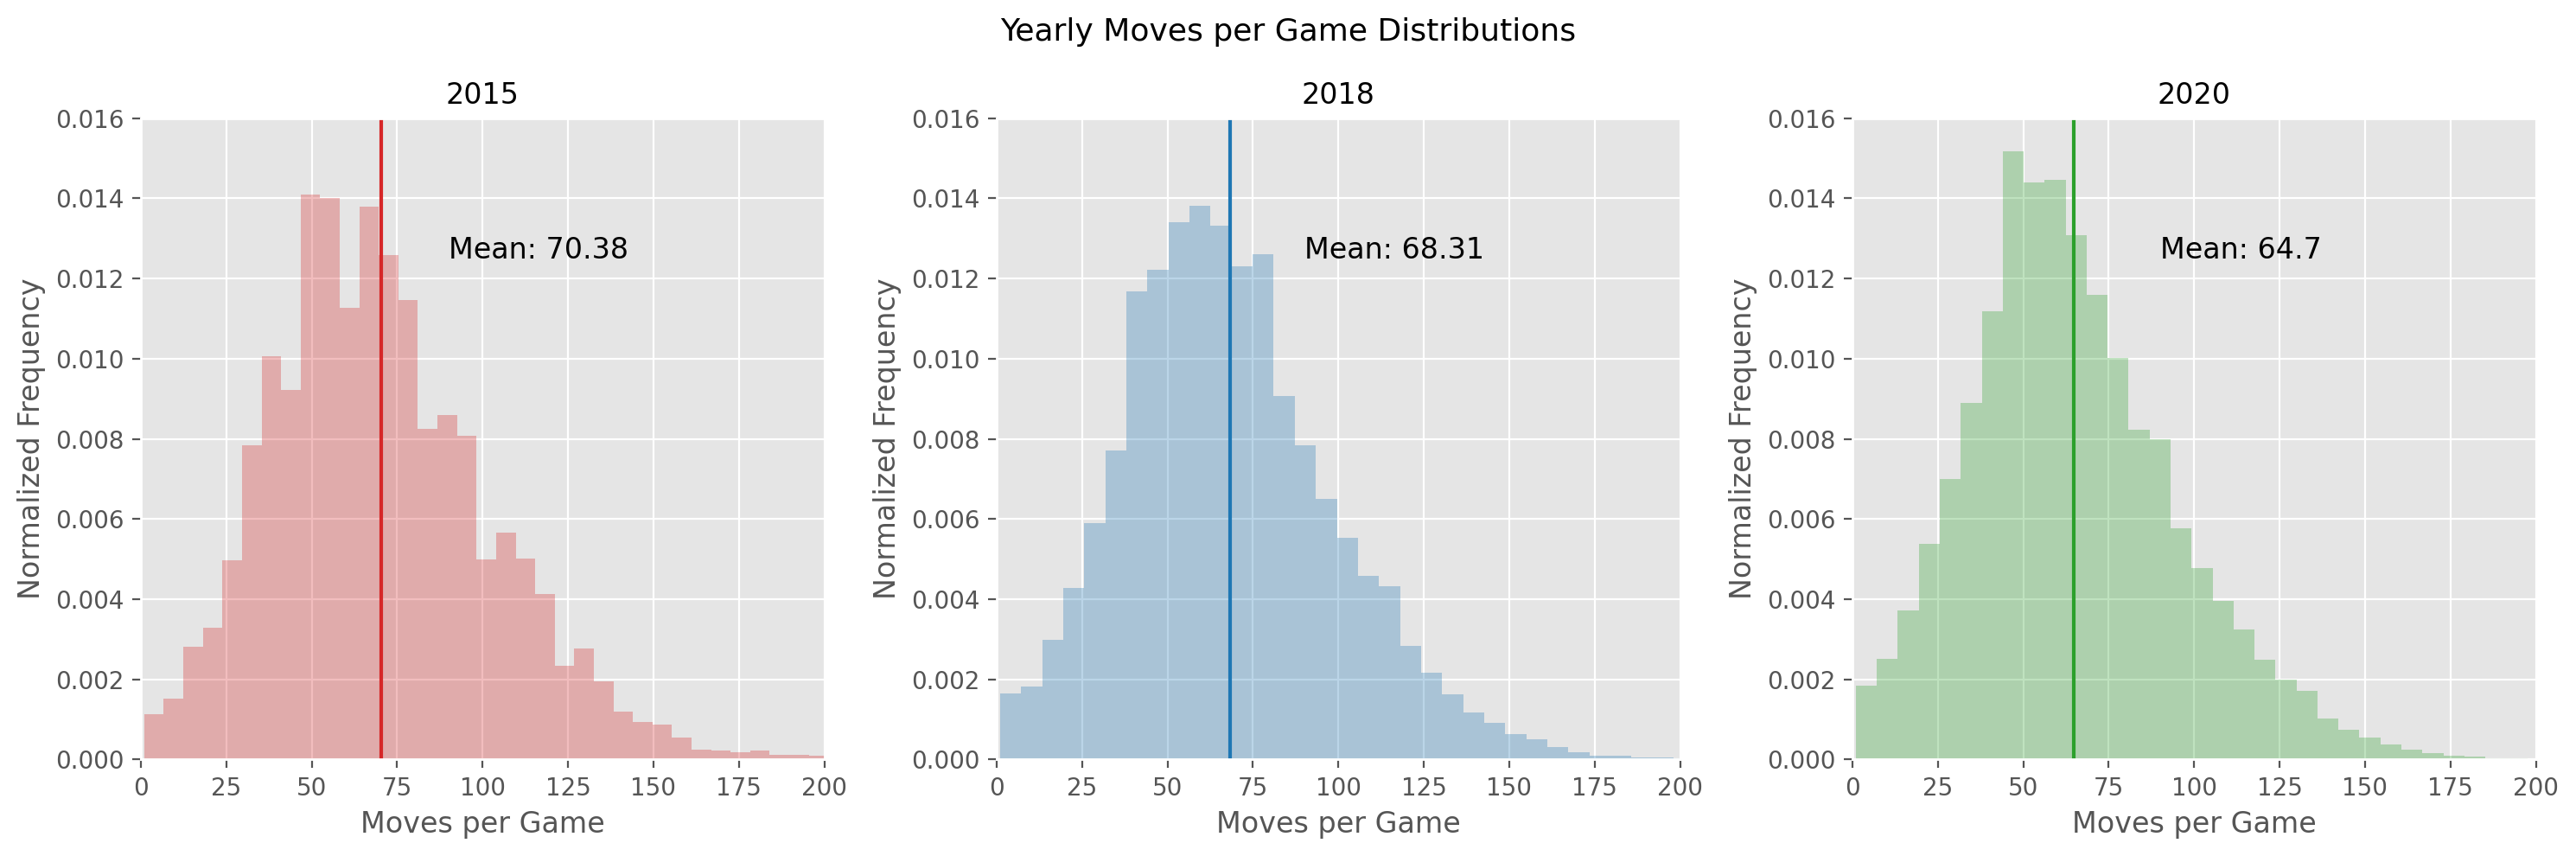

In [228]:
# Individual Year Histograms
years = [2015, 2018, 2020]
colors = ['tab:red', 'tab:blue', 'tab:green']

fig, axs = plt.subplots(1,len(years), figsize=(15,5), dpi=200)
for idx, ax in enumerate(axs.flatten()):
    df = chess_df[chess_df.year==years[idx]].copy(deep=True)
    
    ax.hist(df.total_moves.values,bins=50,density=True, alpha = 0.3, color=colors[idx])
    ax.set_xlim((0,200))
    ax.set_ylim((0,0.016))
    
    ax.set_title('{year}'.format(year=years[idx]),fontsize=12)
    ax.set_xlabel('Moves per Game', fontsize=12)
    ax.set_ylabel('Normalized Frequency', fontsize=12)
    
    ax.axvline(x = df.total_moves.mean(), color=colors[idx])
    ax.text(90, 0.0125, 'Mean: ' + str(round(df.total_moves.mean(), 2)), color='Black', fontsize=12)

fig.suptitle('Yearly Moves per Game Distributions', fontsize=13)    


plt.tight_layout()
plt.savefig('../imgs/year_hist_moves_per_game.png')
plt.show()

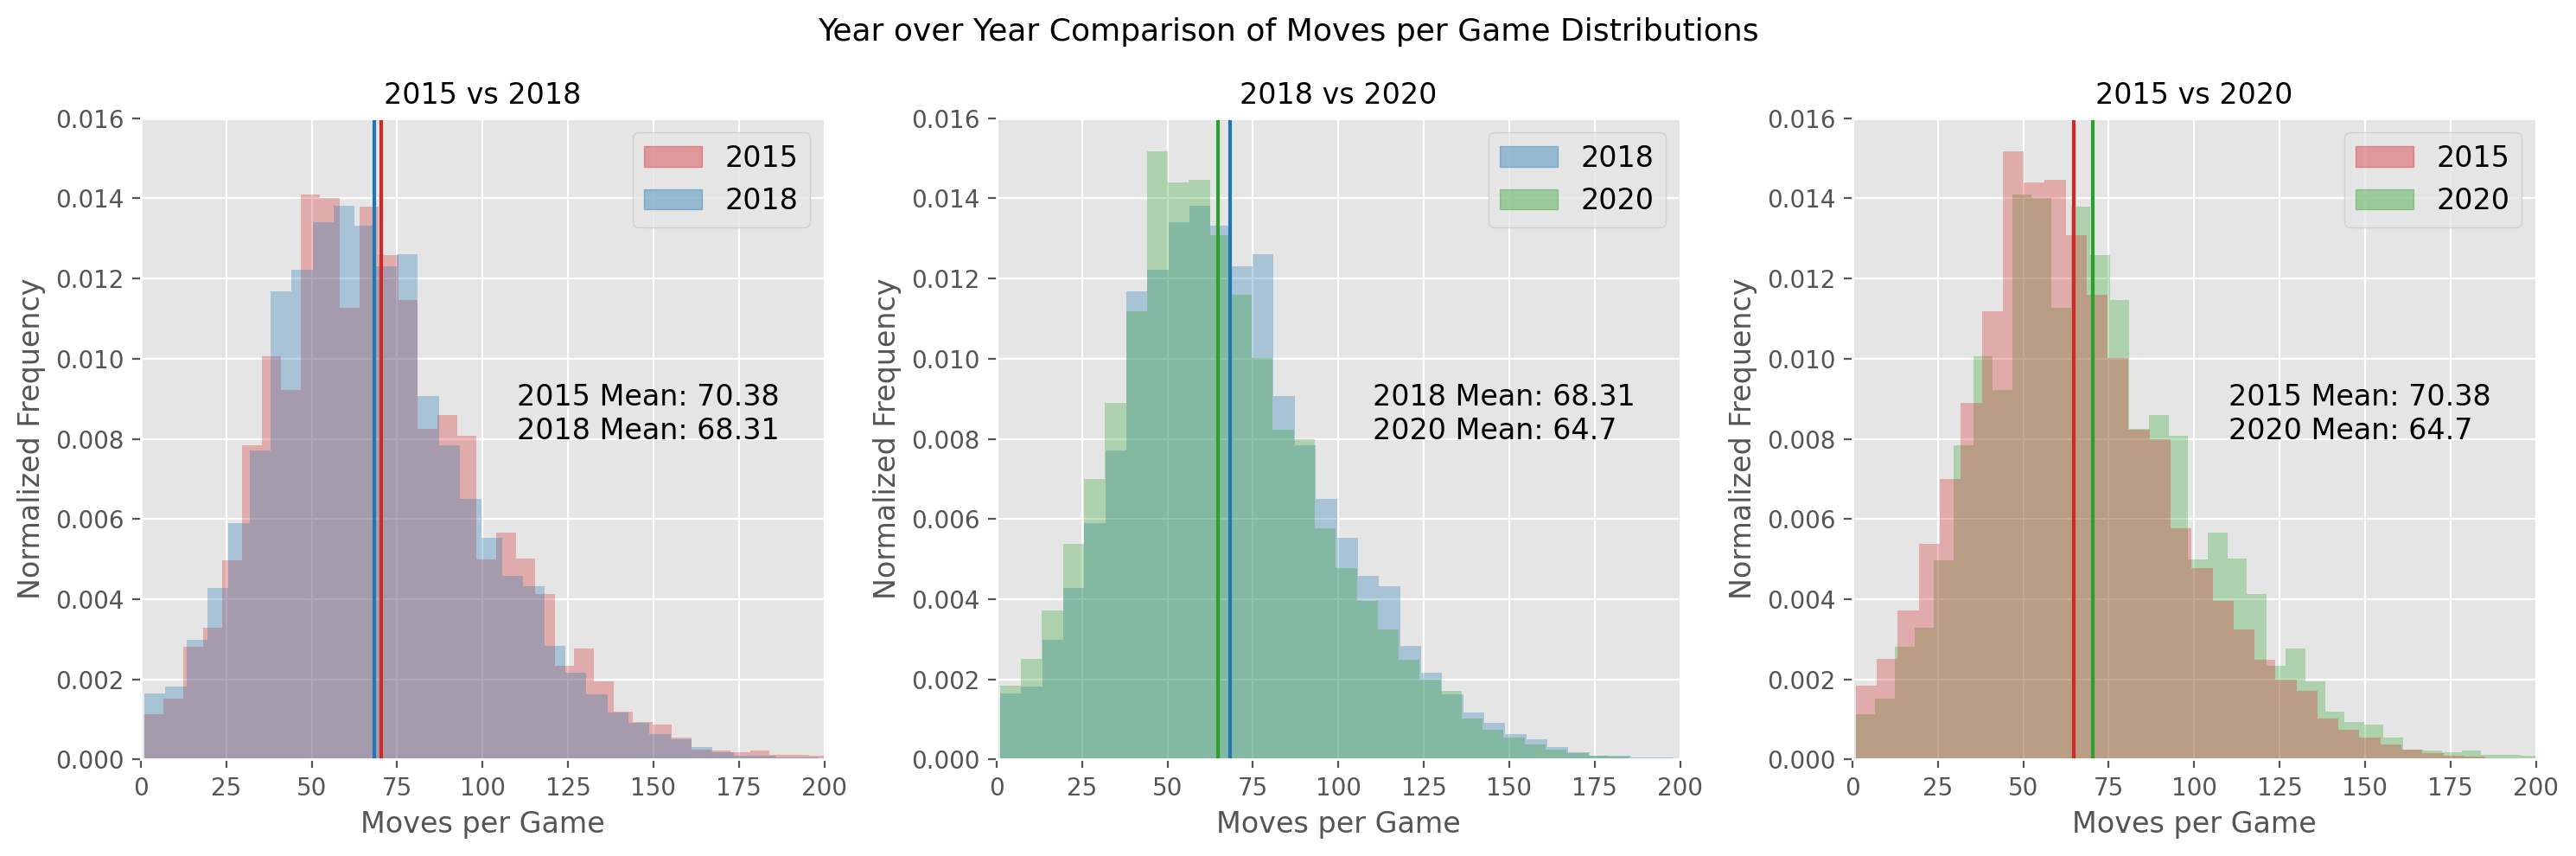

In [222]:
# T-test Histograms overlayed
years = [2015, 2018, 2020, 2015]
colors = ['tab:red', 'tab:blue', 'tab:green','tab:red']
ttests = [ttest_15v18, ttest_15v20, ttest_18v20]
h_2015 = mpatches.Patch(color='tab:red', alpha=0.4, label=2015)
h_2018 = mpatches.Patch(color='tab:blue', alpha=0.4, label=2018)
h_2020 = mpatches.Patch(color='tab:green', alpha=0.4, label=2020)
h=[h_2015, h_2018, h_2020, h_2015]

fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=200)

for idx, ax in enumerate(axs.flatten()):
    year1 = min(years[idx],years[idx+1])
    year2 = max(years[idx],years[idx+1])
    df1 = chess_df[chess_df.year==year1].copy(deep=True)
    df2 = chess_df[chess_df.year==year2].copy(deep=True)

    ax.hist(df1.total_moves.values,bins=50,density=True, alpha = 0.3, color=colors[idx])
    ax.hist(df2.total_moves.values,bins=50,density=True, alpha = 0.3, color=colors[idx+1])
    
    ax.text(110, 0.008, '{year1} Mean: {mean1} \n{year2} Mean: {mean2}'
            .format(year1=year1, year2=year2,mean1=round(df1.total_moves.mean(),2), mean2=round(df2.total_moves.mean(),2)),
            color='Black', fontsize=12, ha='left')
    
    ax.axvline(x = df1.total_moves.mean(), color=colors[idx])
    ax.axvline(x = df2.total_moves.mean(), color=colors[idx+1])
    
    ax.set_title('{year} vs {year2}'.format(year=year1, year2=year2),fontsize=12)
    ax.set_xlabel('Moves per Game', fontsize=12)
    ax.set_ylabel('Normalized Frequency', fontsize=12)
    if idx < 2:
        ax.legend(handles=[h[idx],h[idx+1]], fontsize=12)
    else:
        ax.legend(handles=[h[idx+1],h[idx]], fontsize=12)
    
    ax.set_xlim((0,200))
    ax.set_ylim((0,0.016))

fig.suptitle('Year over Year Comparison of Moves per Game Distributions', fontsize=13)

plt.tight_layout()
plt.savefig('../imgs/YoY_moves_per_game_ttest.png')
plt.show()

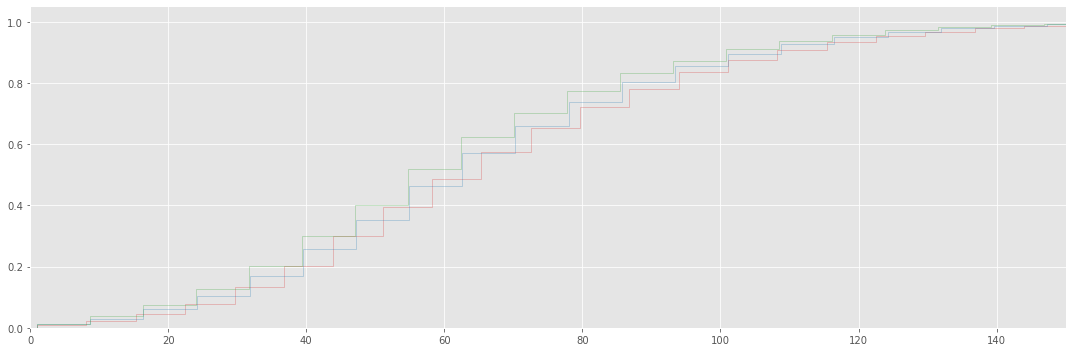

In [134]:
# Overlayed Histogram CDF's
years = [2015, 2018, 2020]
colors = ['tab:red', 'tab:blue', 'tab:green']

fig, ax = plt.subplots(figsize=(15,5))

for idx in range(len(years)):
    df = chess_df[chess_df.year==years[idx]].copy(deep=True)
    # df['normalized'] = df.year / df.year.sum()
    ax.hist(df.total_moves.values,bins=40,density=True, alpha = 0.5, color=colors[idx],cumulative=True,histtype='step')
    ax.set_xlim((0,150))

plt.tight_layout()
plt.show()

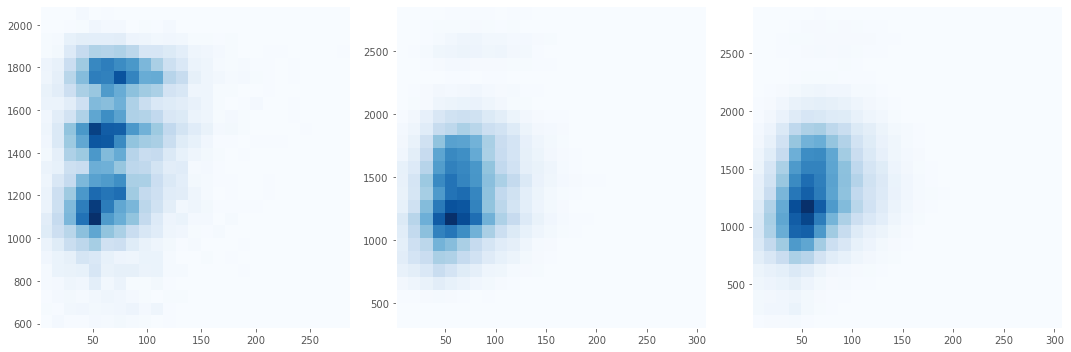

In [118]:
# 2-D Graphs side by side
years = [2015, 2018, 2020]
ELO = [1200,1800,2200,3500]
colors = ['tab:red', 'tab:blue', 'tab:green']
fig, axs = plt.subplots(1,len(years), figsize=(15,5))
for idx, ax in enumerate(axs.flatten()):
    df = chess_df[chess_df.year == years[idx]].copy(deep=True)
    # df['normalized'] = df.year / df.year.sum()
    ax.hist2d(df.total_moves.values, df.avg_rating.values, cmap='Blues', bins = [25,25])

plt.tight_layout()
plt.show()

In [110]:
# & (chess_df.avg_rating > ELO[idx]) & (chess_df.avg_rating < ELO[idx+1])

In [210]:
chess_df.sort_values('avg_rating', ascending=False).username.unique()

array(['rainmond', 'inferna1', 'boundless_strike', 'mikhaillinker',
       'oladipo32', 'loshadka2019', 'scragga', 'ivan_zhukov', 'kilelya',
       'vadim989894', 'kutlubaev_artur', 'agentpapashka', 'goncharov1985',
       'pavel_boy', 'beelva63', 'maximysx', 'joss2010', 'evgeny963',
       'roland2002', 'aas521', 'steeld666', 'zhenya-004', 'indiana2017',
       'adomnitskiy', 'lirik32', 'sagarns', 'kosmonavt1', 'darkmanx85',
       'arkadiikrasnodar', 'mic_2020', 'barinova-marina', 'hungrierwolf',
       'naturplay', 'evgenyartyukhov1992', 'ilyav', 'sotikin',
       'johnn55555', 'toneek', 'zuhrab1989', 'flot-russia', 'anisf77',
       'leon4989', 'pvladimirs', 'masterlevwin', 'penalty88', 'geodezist',
       'gamid2002', 'planetolog', 'dyatlov33', 'feniks85',
       'aleshkov_alexandr', 'proto-1', 'sergey19081960', 'charli-7',
       'realrocknrolla', 'rustambaekenov', 'nii_trino', 'gri6gor',
       'serggggggg', 'pavel_p', 'danilz', 'torota59', 'reeqivanovith',
       'piton206', 'a

In [212]:
chess_df[chess_df.username=='boundless_strike']

,username,white_rating,black_rating,rating_diff,termination,ECO,total_moves,total_turns,moves_list,time_class,rated,date,year,month,day,white,black,pgn,fen,user_color,user_rating,avg_rating
133037,boundless_strike,2378,2342,36,Boundless_Strike won by checkmate,Giuoco-Piano-Game-Giuoco-Pianissimo-Italian-Fo...,123,61,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1c4', 'f8c5...",blitz,True,2018-04-06,2018,4,6,"{'rating': 2378, 'result': 'win', '@id': 'http...","{'rating': 2342, 'result': 'checkmated', '@id'...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",8/8/4r3/5k1K/3Q2P1/3R4/8/8 b - g3,white,2378,2360.0
133038,boundless_strike,2359,2369,10,DaniLuiz94 won on time,Reti-Opening-Nimzowitsch-Larsen-Attack-2...Nf6...,131,65,"['g1f3', 'd7d5', 'b2b3', 'g8f6', 'c1b2', 'g7g6...",blitz,True,2018-04-06,2018,4,6,"{'rating': 2359, 'result': 'win', '@id': 'http...","{'rating': 2369, 'result': 'timeout', '@id': '...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",8/3k4/2p5/2P2PKQ/8/8/8/8 b - -,black,2369,2364.0
133039,boundless_strike,2389,2369,20,Game drawn by timeout vs insufficient material,French-Defense-Schlechter-Variation,156,78,"['e2e4', 'e7e6', 'd2d4', 'd7d5', 'f1d3', 'd5e4...",blitz,True,2018-04-06,2018,4,6,"{'rating': 2389, 'result': 'timevsinsufficient...","{'rating': 2369, 'result': 'timevsinsufficient...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2k5/4Q3/5R2/6K1/8/8/8/8 w - -,black,2369,2379.0
133040,boundless_strike,2377,2381,4,Boundless_Strike won on time,French-Defense-Exchange-Monte-Carlo-Variation-...,123,61,"['e2e4', 'e7e6', 'd2d4', 'd7d5', 'e4d5', 'e6d5...",blitz,True,2018-04-06,2018,4,6,"{'rating': 2377, 'result': 'win', '@id': 'http...","{'rating': 2381, 'result': 'timeout', '@id': '...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4Q3/K5k1/8/6P1/1q6/8/8/8 b - -,white,2377,2379.0
133041,boundless_strike,2387,2432,45,Boundless_Strike won on time,French-Defense-Normal-Variation,121,60,"['e2e4', 'e7e6', 'd2d4', 'b7b6', 'b1c3', 'c8b7...",blitz,True,2018-04-06,2018,4,6,"{'rating': 2387, 'result': 'win', '@id': 'http...","{'rating': 2432, 'result': 'timeout', '@id': '...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4k3/8/5K2/3P1B2/8/8/8/8 b - -,white,2387,2409.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133389,boundless_strike,1474,1465,9,LevRasputin won by checkmate,Grob-Opening-1...e5,28,14,"['g2g4', 'e7e5', 'd2d4', 'b8c6', 'd4d5', 'c6b8...",rapid,False,2020-12-25,2020,12,25,"{'rating': 1474, 'result': 'checkmated', '@id'...","{'rating': 1465, 'result': 'win', '@id': 'http...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",rnb1k2r/pppp1pp1/3b1n1p/8/4p2B/7P/PPQ1PPBq/2R2...,white,1474,1469.5
133390,boundless_strike,1474,1465,9,Boundless_Strike won by resignation,Kings-Fianchetto-Opening-1...d5-2.Bg2-e5-3.c4,81,40,"['g2g3', 'e7e5', 'f1g2', 'd7d5', 'c2c4', 'd5d4...",rapid,False,2020-12-25,2020,12,25,"{'rating': 1474, 'result': 'win', '@id': 'http...","{'rating': 1465, 'result': 'resigned', '@id': ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2Q5/7p/3k2p1/5pK1/7P/6P1/8/8 b - -,white,1474,1469.5
133391,boundless_strike,1474,1465,9,Boundless_Strike won by resignation,Nimzowitsch-Larsen-Attack-Modern-Variation-2.B...,23,11,"['b2b3', 'e7e5', 'c1b2', 'b8c6', 'g2g3', 'd7d5...",rapid,False,2020-12-25,2020,12,25,"{'rating': 1474, 'result': 'win', '@id': 'http...","{'rating': 1465, 'result': 'resigned', '@id': ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",Q3k2r/p1pb1ppp/3b1n2/4p3/8/6P1/PB1PPP1P/2R2RK1...,white,1474,1469.5
133392,boundless_strike,2609,1980,629,Boundless_Strike won on time,Caro-Kann-Defense-Two-Knights-Mindeno-Exchange...,83,41,"['e2e4', 'c7c6', 'b1c3', 'd7d5', 'g1f3', 'c8g4...",blitz,False,2020-12-25,2020,12,25,"{'rating': 2609, 'result': 'win', '@id': 'http...","{'rating': 1980, 'result': 'timeout', '@id': '...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",8/kp4p1/5b1p/pP6/2Q